In [64]:
# --- Minimal N-in-a-row board (extracted & trimmed) ---
import numpy as np
from itertools import product

class Board:
    """
    Internal state encoding:
        0 = empty, 1 = X, 2 = O
    Dataset/serialized encoding used below swaps X/O to (2,1) when needed.
    """
    def __init__(self, dimensions, x_in_a_row):
        self.dimensions = tuple(int(d) for d in dimensions)
        self.nd = len(self.dimensions)
        self.x_in_a_row = int(x_in_a_row)
        self.state = np.zeros(self.dimensions, dtype=np.int8)
        self.turn = 1  # 1=X, 2=O
        self._dirs = self._make_dirs()

    def _make_dirs(self):
        # unique directions from {-1,0,1}^nd \ {0}, keeping those whose first nonzero > 0
        dirs = []
        for v in product((-1, 0, 1), repeat=self.nd):
            if all(c == 0 for c in v):
                continue
            keep = False
            for c in v:
                if c < 0:
                    keep = False
                    break
                if c > 0:
                    keep = True
                    break
            if keep:
                dirs.append(tuple(v))
        return dirs

    def possible_moves(self):
        return np.argwhere(self.state == 0).astype(np.int64, copy=False)

    def push(self, coord):
        pos = tuple(int(p) for p in coord)
        if self.state[pos] != 0:
            raise ValueError("occupied")
        self.state[pos] = np.int8(self.turn)
        self.turn = 2 if self.turn == 1 else 1

    def board_blob_encoding(self):
        """
        Convert internal 0/1/2 to dataset encoding X=2, O=1 (for parity with your dataset).
        """
        arr = np.zeros_like(self.state, dtype=np.int8)
        it = np.nditer(self.state, flags=['multi_index'])
        while not it.finished:
            v = int(it[0])
            if v == 1:   # X
                arr[it.multi_index] = 2
            elif v == 2: # O
                arr[it.multi_index] = 1
            it.iternext()
        return arr

def flatten_index(move, dims):
    idx = 0
    for i, c in enumerate(move):
        stride = 1
        for d in dims[i + 1:]:
            stride *= d
        idx += c * stride
    return idx

def unflatten_index(idx, dims):
    coords = []
    for i in range(len(dims) - 1):
        stride = int(np.prod(dims[i + 1:]))
        q, idx = divmod(idx, stride)
        coords.append(int(q))
    coords.append(int(idx))
    return tuple(coords)


In [65]:
import numpy as np
from itertools import product

def enumerate_lines(dimensions, k):
    """
    Return all possible contiguous lines of length k in an n-dimensional board.
    Each line is a list of coordinate tuples.
    """
    dims = tuple(dimensions)
    nd = len(dims)

    # same canonical direction logic as Board._make_dirs
    dirs = []
    for v in product((-1, 0, 1), repeat=nd):
        if all(c == 0 for c in v):
            continue
        keep = False
        for c in v:
            if c < 0:
                keep = False
                break
            if c > 0:
                keep = True
                break
        if keep:
            dirs.append(tuple(v))

    lines = []
    for v in dirs:
        starts = []
        for i, d in enumerate(dims):
            step = v[i]
            if step == 0:
                starts.append(range(0, d))
            elif step == 1:
                starts.append(range(0, d - k + 1))
            else:  # step == -1
                starts.append(range(k - 1, d))

        for idx in np.ndindex(*(len(r) for r in starts)):
            s = [starts[i][idx[i]] for i in range(nd)]
            line = []
            for t in range(k):
                q = tuple(s[i] + t * v[i] for i in range(nd))
                if any(q[i] < 0 or q[i] >= dims[i] for i in range(nd)):
                    break
                line.append(q)
            if len(line) == k:
                lines.append(line)
    return lines


In [66]:
from lime.lime_tabular import LimeTabularExplainer

def make_line_feature_model_wrapper(model_predict_proba, instance_board, dimensions, k):
    """
    Returns (predict_fn, feature_names, decode_fn)
      - predict_fn(Z): Z is (n_samples, n_lines) binary; returns proba for each sample
      - feature_names: ["L0: (...)", "L1: (...)", ...] human labels
      - decode_fn(z): helper to reconstruct a perturbed board from a single binary z
    """
    lines = enumerate_lines(dimensions, k)
    n_lines = len(lines)
    dims = tuple(dimensions)

    # flatten helpers for fast masking/combining
    idx_lines = []
    for line in lines:
        idx_lines.append([flatten_index(coord, dims) for coord in line])

    instance_flat = instance_board.reshape(-1).copy()

    def decode_from_z(z):
        # Start from empty board; then "union" cells from lines where z==1
        out_flat = np.zeros_like(instance_flat)
        active = np.where(z.astype(bool))[0]
        if active.size:
            for li in active:
                for fi in idx_lines[int(li)]:
                    out_flat[fi] = instance_flat[fi]
        return out_flat.reshape(dims)

    def predict_fn(Z):
        # Z shape: (n_samples, n_lines)
        boards = np.stack([decode_from_z(z) for z in Z], axis=0)
        # model_predict_proba should accept (n_samples, *dims) or (n_samples, D*H*W)
        return model_predict_proba(boards)

    # readable feature names: e.g., "L12: (0,0)->(0,2)"
    feature_names = []
    for i, line in enumerate(lines):
        feature_names.append(f"L{i}: {line[0]}→{line[-1]}")

    return predict_fn, feature_names, decode_from_z


In [67]:
# === Load checkpoint-defined MLP (65->128->64->64->out) and connect to LIME ===
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

CKPT_PATH = "large-3x3-e20-b128-sarsa-sp100.pt"

# --- Load checkpoint (handle common wrappers like 'state_dict') ---
raw = torch.load(CKPT_PATH, map_location="cpu")
if isinstance(raw, dict):
    for k_ in ["state_dict", "model_state_dict", "net", "model"]:
        if k_ in raw and isinstance(raw[k_], dict):
            state_dict = raw[k_]
            break
    else:
        state_dict = raw
else:
    state_dict = raw  # already an OrderedDict

# --- Infer linear layer sizes from weight tensors to reconstruct the MLP ---
linear_w = []
for name, tensor in state_dict.items():
    if name.endswith(".weight") and isinstance(tensor, torch.Tensor) and tensor.ndim == 2:
        m = re.search(r"\.(\d+)\.weight$", name)
        idx = int(m.group(1)) if m else 10**6
        linear_w.append((idx, name, tensor.shape))  # (order, name, (out, in))
linear_w.sort(key=lambda x: (x[0], x[1]))
if not linear_w:
    raise RuntimeError("No Linear weights found in checkpoint; cannot infer architecture.")

sizes = []
for i, (_, _, (out_f, in_f)) in enumerate(linear_w):
    if i == 0:
        sizes.append(in_f)
    sizes.append(out_f)
in_features_ckpt = sizes[0]   # e.g., 65 if it's 64 board + 1 turn
out_size = sizes[-1]          # number of classes from last Linear

# --- Rebuild the MLP: Linear + ReLU between all but the last Linear ---
layers = []
for i in range(len(sizes) - 1):
    layers.append(nn.Linear(sizes[i], sizes[i+1]))
    if i < len(sizes) - 2:
        layers.append(nn.ReLU())
DynamicMLP = nn.Sequential(*layers)

class Wrapper(nn.Module):
    def __init__(self, core: nn.Sequential):
        super().__init__()
        self.net = core
    def forward(self, x):
        return self.net(x)

model = Wrapper(DynamicMLP)
try:
    model.load_state_dict(state_dict, strict=True)
except RuntimeError as e:
    print("Strict load failed; retrying non-strict.\n", e)
    model.load_state_dict(state_dict, strict=False)

model.eval()
device = torch.device("cpu")
model.to(device)

def make_predict_proba_fn(dims, turn_feature: float = 0.0):
    """
    Returns a function model_predict_proba_from_boards(boards_batch) compatible with LIME.
    - dims: tuple like (4,4,4)
    - turn_feature: scalar appended if checkpoint expects an extra feature (e.g., 'whose turn')
    """
    BOARD_FEATS = int(np.prod(dims))
    need_extra = (in_features_ckpt == BOARD_FEATS + 1)

    def model_predict_proba_from_boards(boards_batch: np.ndarray) -> np.ndarray:
        n = boards_batch.shape[0]
        X = boards_batch.reshape(n, -1).astype("float32")
        if need_extra:
            extra = np.full((n, 1), float(turn_feature), dtype="float32")
            X = np.concatenate([X, extra], axis=1)
        with torch.no_grad():
            t = torch.from_numpy(X).to(device)
            logits = model(t)
            probs = F.softmax(logits, dim=1)
        return probs.cpu().numpy()

    return model_predict_proba_from_boards


In [68]:
# Match training geometry
dims = (3, 3)
k = 3

# Make a sample playable board
b = Board(dims, k)
b.push((0, 0))  # X
b.push((1, 1))  # O
b.push((0, 1))  # X
b.push((1, 0))  # O

# Choose encoding to match training.
instance_board = b.board_blob_encoding().copy()

# Turn feature used by the checkpoint
TURN_FEATURE = 1.0 if b.turn == 1 else 0.0 
print("instance_board shape:", instance_board.shape)
print("Current turn:", "X" if b.turn == 1 else "O")


instance_board shape: (3, 3)
Current turn: X


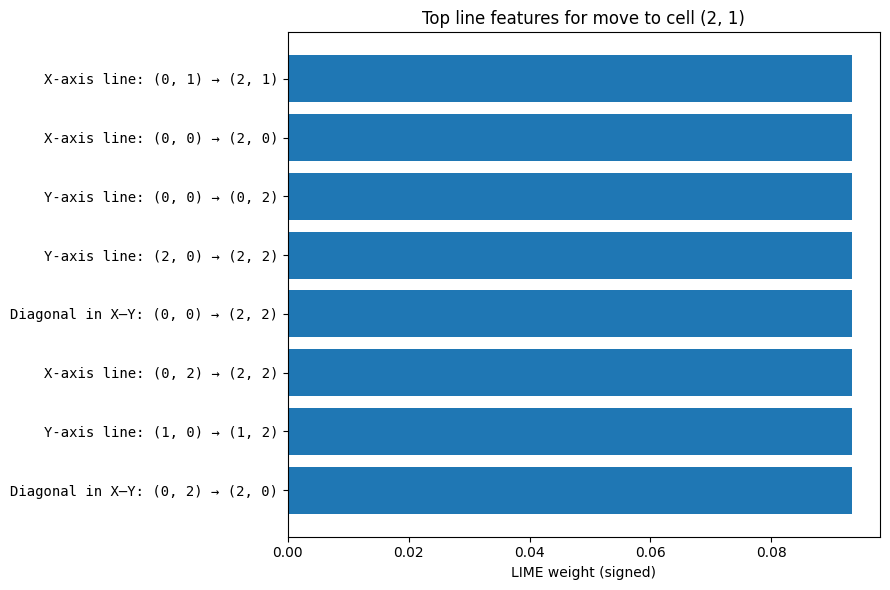

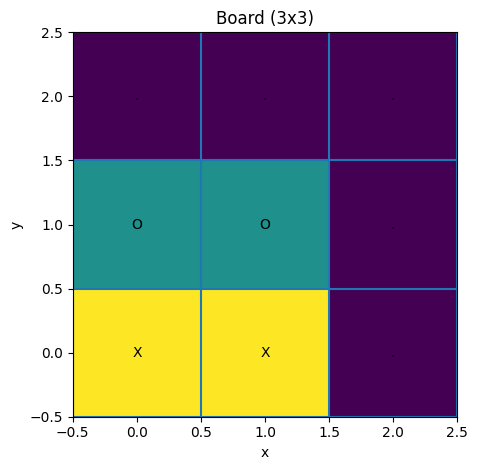

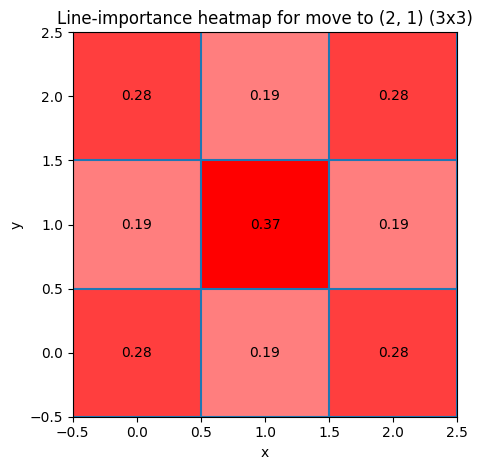

In [69]:
import re
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Build a prediction callable for LIME
model_predict_proba_from_boards = make_predict_proba_fn(dims, TURN_FEATURE)

# Wrap the model for LIME line-based features
predict_fn, feature_names, decode_fn = make_line_feature_model_wrapper(
    model_predict_proba=model_predict_proba_from_boards,
    instance_board=instance_board,
    dimensions=dims,
    k=k
)

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.zeros((1, len(feature_names))),
    feature_names=feature_names,
    # Each output index is interpreted as "move (row, col)" on the board
    class_names=[f"move {unflatten_index(i, dims)}" for i in range(out_size)],
    discretize_continuous=False,
    categorical_features=list(range(len(feature_names))),
    categorical_names={i: ["off", "on"] for i in range(len(feature_names))},
    mode="classification"
)

# Explain the current board instance
z0 = np.ones(len(feature_names), dtype=int)  # all lines active

# --- pick a LEGAL move to explain: model's best move among empty cells ---
probs = model_predict_proba_from_boards(instance_board[None, ...])[0]  # (out_size,)

empties = np.argwhere(instance_board == 0)
empty_indices = [flatten_index(tuple(c), dims) for c in empties]

# best legal move: highest probability among empty cells
best_legal = max(empty_indices, key=lambda idx: probs[idx])

target_class = best_legal                         # index of the move/output we are explaining
target_move_coord = unflatten_index(target_class, dims)  # e.g. (2, 1)

exp = explainer.explain_instance(
    data_row=z0,
    predict_fn=predict_fn,
    num_features=10,
    labels=[target_class],
    num_samples=5000
)

# ---------- define `top` and project to cells ----------
# enumerate all possible lines for this board
lines = enumerate_lines(dims, k)

# collect top features from LIME with their parsed line index
top = []
for fn, w in exp.as_list(label=target_class):
    m = re.match(r"L(\d+):", fn)        # feature name like "L3: (0,0)→(2,2)"
    li = int(m.group(1)) if m else None
    top.append((fn, w, li))

# build cell-level importance by summing line weights over the cells each line covers
cell_importance = np.zeros(dims, dtype=float)
for _, w, li in top:
    if li is None or li >= len(lines):
        continue
    for coord in lines[li]:
        cell_importance[coord] += w
# -------------------------------------------------------

# Describe a line by which axes change between its start and end
def describe_direction(start, end):
    delta = np.array(end) - np.array(start)
    axes = ['X', 'Y', 'Z', 'W', 'V']  # supports up to 5D
    active = [axes[i] for i, d in enumerate(delta) if d != 0]
    if len(active) == 1:
        return f"{active[0]}-axis line"
    if len(active) == 2:
        return f"Diagonal in {active[0]}–{active[1]}"
    if len(active) == 3:
        return "Main 3D diagonal"
    return "Mixed direction"

# Build human-readable labels for the TOP features we’re plotting
readable_top = []
for fn, w, li in top:
    if li is None or li >= len(lines):
        label = fn  # fallback
    else:
        start, end = lines[li][0], lines[li][-1]
        label = f"{describe_direction(start, end)}: {start} → {end}"
    readable_top.append((label, w))

# Wrap long labels to fit nicely
def wrap_label(s, width=34):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

labels = [wrap_label(lbl) for (lbl, _) in readable_top]
weights = [w for (_, w) in readable_top]

# Plot (reverse order so the most important is at top)
idx = np.arange(len(weights))
plt.figure(figsize=(9, 6))
plt.barh(idx[::-1], np.array(weights)[::-1])
plt.yticks(idx[::-1], labels[::-1], fontfamily="monospace")
plt.xlabel("LIME weight (signed)")
plt.title(f"Top line features for move to cell {target_move_coord}")
plt.tight_layout()
plt.show()

# Helpers for drawing the board and importance heatmaps (2D 3x3 version)
def draw_board(board_2d: np.ndarray, title: str):
    assert board_2d.shape == dims
    B = board_2d
    plt.figure()
    plt.imshow(B, vmin=0, vmax=B.max() if B.max() > 0 else 1)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    for i in range(B.shape[0] + 1):
        plt.axhline(i - 0.5)
    for j in range(B.shape[1] + 1):
        plt.axvline(j - 0.5)
    for y in range(B.shape[0]):
        for x in range(B.shape[1]):
            v = int(B[y, x])
            ch = "X" if v == 2 else ("O" if v == 1 else ".")
            plt.text(x, y, ch, ha="center", va="center")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def draw_importance(imp_2d: np.ndarray, title: str):
    H = imp_2d
    plt.figure()
    vmax = np.max(np.abs(H)) or 1.0
    plt.imshow(H, cmap="bwr", vmin=-vmax, vmax=vmax)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    for i in range(H.shape[0] + 1):
        plt.axhline(i - 0.5)
    for j in range(H.shape[1] + 1):
        plt.axvline(j - 0.5)
    for y in range(H.shape[0]):
        for x in range(H.shape[1]):
            val = H[y, x]
            if abs(val) > 1e-9:
                plt.text(x, y, f"{val:.2f}", ha="center", va="center")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# For 3x3 (2D), just draw the board and importance once
draw_board(instance_board, title="Board (3x3)")
draw_importance(cell_importance, title=f"Line-importance heatmap for move to {target_move_coord} (3x3)")


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


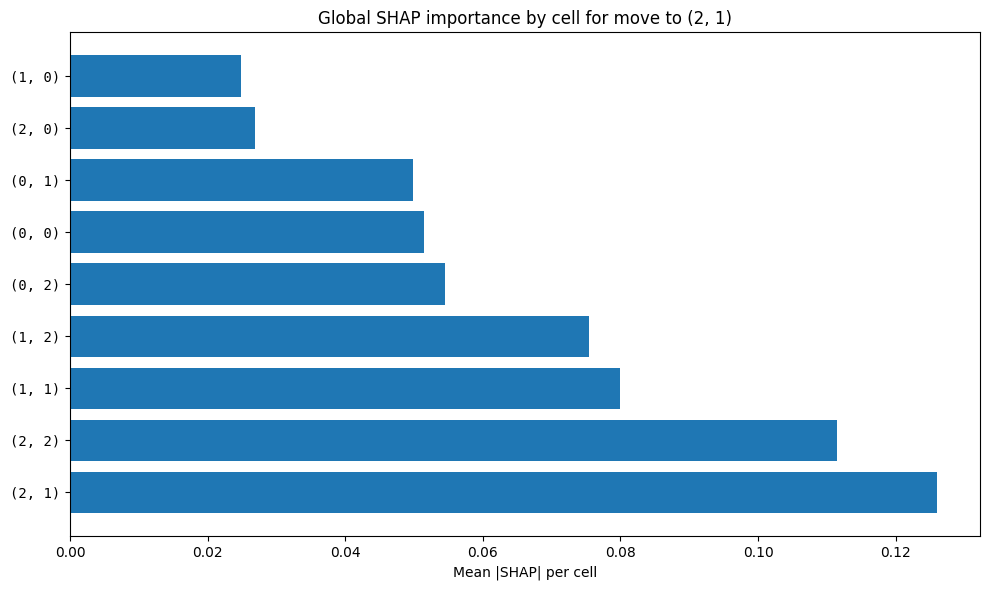

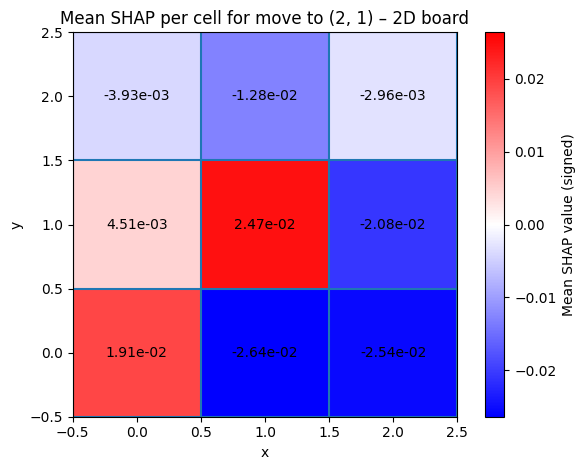

In [70]:
# Computes SHAP values for random boards, showing cell-level feature importance trends.
# Optimized with shap.sample() for speed and updated with signed blue-red SHAP heatmaps.
# This version uses the SAME move that LIME is explaining: target_class / target_move_coord.

import numpy as np
import matplotlib.pyplot as plt
import shap

# --- Helpers (needed early) ---
def unflatten_index(idx, dims):
    coords = []
    for i in range(len(dims) - 1):
        stride = int(np.prod(dims[i + 1:]))
        q, idx = divmod(idx, stride)
        coords.append(int(q))
    coords.append(int(idx))
    return tuple(coords)

# --- Decide which move (output index) SHAP should explain ---
try:
    # If the LIME cell has been run, reuse its target
    global_shap_target_idx = int(target_class)
    global_shap_move_coord = tuple(target_move_coord)
except NameError:
    # Fallback: explain move index 0 (top-left) if LIME hasn't been run yet
    global_shap_target_idx = 0
    global_shap_move_coord = unflatten_index(0, dims)

# --- Build random board samples to represent the global distribution ---
BOARD_FEATS = int(np.prod(dims))

def random_board(dims, k, max_moves=5):
    b = Board(dims, k)
    num_moves = np.random.randint(0, max_moves + 1)
    empties = list(map(tuple, np.argwhere(b.state == 0)))
    np.random.shuffle(empties)
    for mv in empties[:num_moves]:
        b.push(mv)
    board = b.board_blob_encoding().astype(np.float32)
    turn = 1.0 if b.turn == 1 else 0.0
    return board, turn

N_BG, N_TEST = 200, 120
bg_boards, bg_turns = zip(*[random_board(dims, k) for _ in range(N_BG)])
te_boards, te_turns = zip(*[random_board(dims, k) for _ in range(N_TEST)])

bgX_cells = np.stack(bg_boards).reshape(N_BG, -1)
teX_cells = np.stack(te_boards).reshape(N_TEST, -1)
bgT = np.array(bg_turns, dtype=np.float32)[:, None]
teT = np.array(te_turns, dtype=np.float32)[:, None]

try:
    needs_turn = (in_features_ckpt == BOARD_FEATS + 1)
except NameError:
    needs_turn = False

if needs_turn:
    bgX = np.concatenate([bgX_cells, bgT], axis=1)
    teX = np.concatenate([teX_cells, teT], axis=1)
else:
    bgX, teX = bgX_cells, teX_cells

# --- Downsample background and test sets for speed ---
BG_KEEP = 25
TE_KEEP = 40
bgX_small = shap.sample(bgX, BG_KEEP, random_state=42)
teX_small = shap.sample(teX, TE_KEEP, random_state=42)

# --- Vectorized prediction function (handles TURN without per-row loops) ---
def shap_predict_fast(X):
    X = np.asarray(X, dtype=np.float32)
    boards = X[:, :BOARD_FEATS].reshape(-1, *dims)
    if not needs_turn:
        pp = make_predict_proba_fn(dims, 0.0)
        return pp(boards)
    turn_mask = X[:, BOARD_FEATS] > 0.5
    pp0 = make_predict_proba_fn(dims, 0.0)
    pp1 = make_predict_proba_fn(dims, 1.0)
    out = np.empty((X.shape[0], out_size), dtype=np.float32)
    if turn_mask.any():
        out[turn_mask] = pp1(boards[turn_mask])
    if (~turn_mask).any():
        out[~turn_mask] = pp0(boards[~turn_mask])
    return out

# --- Kernel SHAP computation ---
explainer = shap.KernelExplainer(shap_predict_fast, bgX_small)
NSAMPLES = 5000
shap_values = explainer.shap_values(teX_small, nsamples=NSAMPLES)

# Use the SAME output neuron that LIME explained (or fallback)
SV = shap_values[global_shap_target_idx] if isinstance(shap_values, list) else shap_values

# --- Ensure SV is 2D (n_samples × n_features) ---
if isinstance(SV, list):
    SV = SV[global_shap_target_idx]
if SV.ndim == 3:
    SV = SV[:, :, global_shap_target_idx]
if SV.ndim != 2:
    raise ValueError(f"Unexpected SHAP output shape {SV.shape}")

n_samples, n_features = SV.shape

# Strip TURN column for cell-wise analysis
if needs_turn and n_features == BOARD_FEATS + 1:
    SV_cells = SV[:, :BOARD_FEATS]
else:
    SV_cells = SV[:, :BOARD_FEATS] if n_features >= BOARD_FEATS else SV

# --- Full per-cell SHAP ranking (all 9 cells for 3x3) ---
cell_import = np.mean(np.abs(SV_cells), axis=0)
order = np.argsort(-cell_import)
cell_labels = [f"{unflatten_index(i, dims)}" for i in order]
cell_scores = cell_import[order]

plt.figure(figsize=(10, max(6, len(cell_scores) * 0.25)))
y = np.arange(len(cell_scores))
plt.barh(y[::-1], cell_scores[::-1])
plt.yticks(y[::-1], cell_labels[::-1], fontfamily="monospace")
plt.xlabel("Mean |SHAP| per cell")
plt.title(f"Global SHAP importance by cell for move to {global_shap_move_coord}")
plt.tight_layout()
plt.show()

# --- 2D heatmap (signed mean SHAP, blue=neg, red=pos) ---
mean_signed = np.mean(SV_cells, axis=0)
expected = int(np.prod(dims))
if mean_signed.size != expected:
    raise ValueError(
        f"Cannot reshape mean_signed of length {mean_signed.size} into dims {dims} (expected {expected})."
    )

mean_signed_2d = mean_signed.reshape(dims)

plt.figure()
vmax = np.max(np.abs(mean_signed_2d)) or 1.0
plt.imshow(mean_signed_2d, cmap="bwr", vmin=-vmax, vmax=vmax)
plt.title(f"Mean SHAP per cell for move to {global_shap_move_coord} – 2D board")
plt.xlabel("x"); plt.ylabel("y")
for i in range(mean_signed_2d.shape[0] + 1): plt.axhline(i - 0.5)
for j in range(mean_signed_2d.shape[1] + 1): plt.axvline(j - 0.5)
for yy in range(mean_signed_2d.shape[0]):
    for xx in range(mean_signed_2d.shape[1]):
        v = mean_signed_2d[yy, xx]
        if abs(v) > 1e-12:
            plt.text(xx, yy, f"{v:.2e}", ha="center", va="center", color="black")
plt.colorbar(label="Mean SHAP value (signed)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Found 1498 boards where X is one move away from winning.
near_win_blob shape: (1498, 3, 3)
near_win_cells shape: (1498, 9)
near_win_full shape: (1498, 10)
Model chooses a winning move in 131 / 1498 near-win boards (8.7%).
Mean probability assigned to some winning move: 0.07835006713867188
Explaining a FAILURE example at index: 0


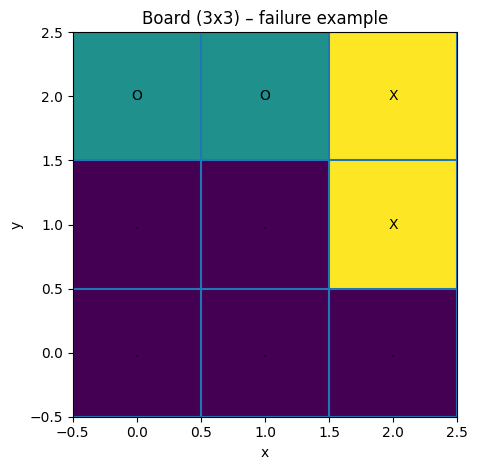

Best action index: 7 → coord (2, 1)
Cell contents at that coord: 2.0
Illegal? True
Winning coords for X on this board: [(np.int64(0), np.int64(2))]
Winning action indices: [2]


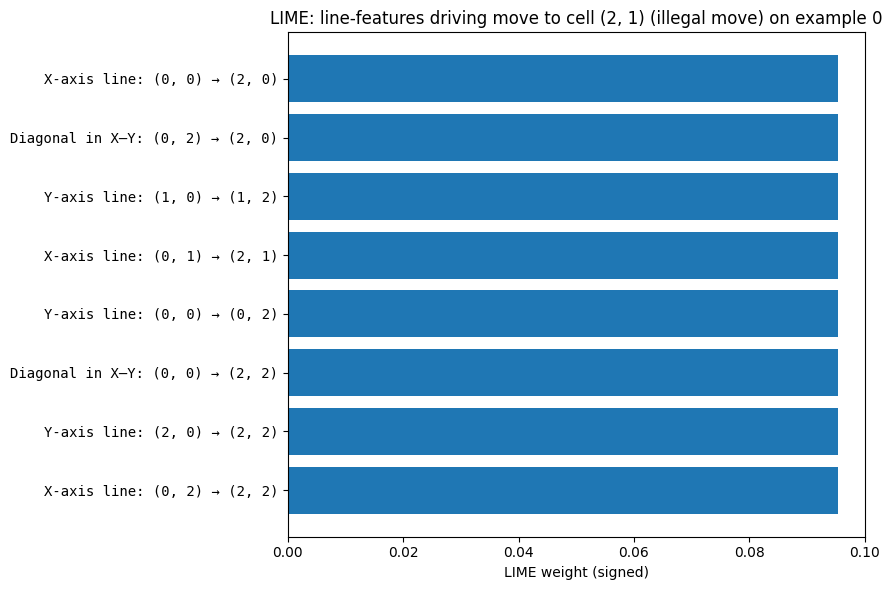

100%|██████████| 1/1 [00:00<00:00, 59.95it/s]


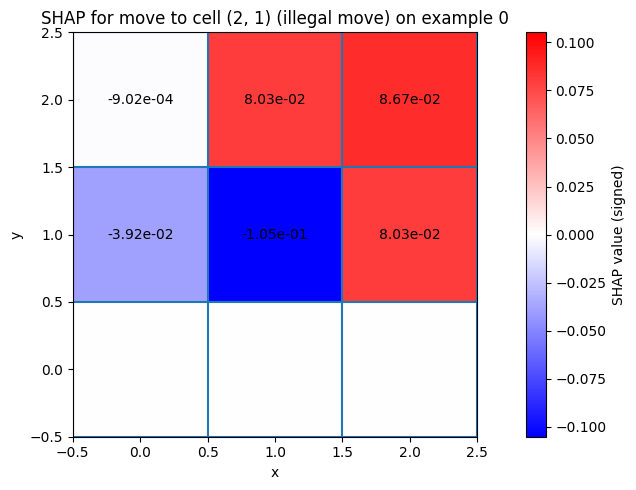

In [71]:
# Analyze "X is one move away from winning" boards:
# - Enumerate all such boards
# - Check if the model chooses a winning move
# - Use LIME and SHAP to explain the *chosen* move (often illegal)

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import textwrap
import re

# --- Geometry: 3x3, 3 in a row ---
dims = (3, 3)
k = 3
BOARD_FEATS = int(np.prod(dims))

# --- Precompute all winning lines for this geometry ---
lines = enumerate_lines(dims, k)

def has_win(arr, player_val: int) -> bool:
    """Check if the given board (internal encoding) has a win for player_val (1=X, 2=O)."""
    for line in lines:
        vals = [arr[c] for c in line]
        if all(v == player_val for v in vals):
            return True
    return False

def flatten_index(coord, dims):
    idx = 0
    for i, c in enumerate(coord):
        stride = int(np.prod(dims[i + 1:])) if i < len(dims) - 1 else 1
        idx += c * stride
    return int(idx)

def class_to_coord(cls, dims):
    rows, cols = dims
    r = int(cls // cols)
    c = int(cls % cols)
    return (r, c)

def move_label_from_index(i, dims):
    r, c = class_to_coord(i, dims)
    return f"move ({r}, {c})"

# --- Enumerate near-win boards: X to move, one move from winning ---
near_win_states = []      # internal encoding, shape (3,3), X=1, O=2
near_win_win_coords = []  # list of coordinates where X can win immediately

for flat in product((0, 1, 2), repeat=BOARD_FEATS):
    arr = np.array(flat, dtype=np.int8).reshape(dims)

    x_count = int((arr == 1).sum())
    o_count = int((arr == 2).sum())

    # X to move: X and O have played same number of moves
    if x_count != o_count:
        continue

    # No existing win on board
    if has_win(arr, 1) or has_win(arr, 2):
        continue

    # Find all empty squares where X would win immediately
    winning_moves = []
    empties = list(zip(*np.where(arr == 0)))
    for coord in empties:
        tmp = arr.copy()
        tmp[coord] = 1  # X plays here
        if has_win(tmp, 1):
            winning_moves.append(coord)

    if winning_moves:
        near_win_states.append(arr)
        near_win_win_coords.append(winning_moves)

near_win_states = (
    np.stack(near_win_states, axis=0)
    if near_win_states
    else np.zeros((0, *dims), dtype=np.int8)
)
print(f"Found {near_win_states.shape[0]} boards where X is one move away from winning.")

# --- Encode boards for the model (dataset encoding: X=2, O=1) ---
near_win_blob = []
for st in near_win_states:
    b = Board(dims, k)
    b.state = st.copy()
    b.turn = 1  # X to move
    near_win_blob.append(b.board_blob_encoding().astype(np.float32))

near_win_blob = (
    np.stack(near_win_blob, axis=0)
    if len(near_win_blob) > 0
    else np.zeros((0, *dims), dtype=np.float32)
)
near_win_cells = near_win_blob.reshape(-1, BOARD_FEATS).astype(np.float32)

try:
    needs_turn = (in_features_ckpt == BOARD_FEATS + 1)
except NameError:
    needs_turn = False

if needs_turn:
    turn_col = np.ones((near_win_cells.shape[0], 1), dtype=np.float32)  # X to move
    near_win_full = np.concatenate([near_win_cells, turn_col], axis=1)
else:
    near_win_full = near_win_cells

print("near_win_blob shape:", near_win_blob.shape)      # (N, 3, 3)
print("near_win_cells shape:", near_win_cells.shape)    # (N, 9)
print("near_win_full shape:", near_win_full.shape)      # (N, 9 or 10)")

# --- Model prediction over actions (assume out_size == number of actions) ---
model_predict_proba_from_boards = make_predict_proba_fn(dims, turn_feature=1.0)  # X to move
probs = model_predict_proba_from_boards(near_win_blob)  # shape: (N, out_size)

if probs.shape[1] != BOARD_FEATS:
    print("Warning: out_size != BOARD_FEATS, cannot directly map outputs to board cells.")
else:
    # For each near-win board, check whether the model's argmax is one of the winning moves
    takes_win = []
    win_probs = []
    for i in range(near_win_blob.shape[0]):
        winning_coords = near_win_win_coords[i]
        winning_indices = [flatten_index(c, dims) for c in winning_coords]
        p = probs[i]
        best_action = int(np.argmax(p))
        takes_win.append(best_action in winning_indices)
        win_probs.append(np.max(p[winning_indices]) if winning_indices else 0.0)

    takes_win = np.array(takes_win, dtype=bool)
    win_probs = np.array(win_probs, dtype=np.float32)

    print(
        f"Model chooses a winning move in {takes_win.sum()} / {len(takes_win)} near-win boards "
        f"({100.0 * takes_win.mean():.1f}%)."
    )
    print("Mean probability assigned to some winning move:", float(win_probs.mean()))

    # Pick one example to explain: first failure if any, otherwise index 0
    if (~takes_win).any():
        idx_ex = int(np.where(~takes_win)[0][0])
        print("Explaining a FAILURE example at index:", idx_ex)
    else:
        idx_ex = 0
        print("Model always takes a winning move; explaining example index:", idx_ex)

    # -------- Example board & chosen (possibly illegal) move --------
    example_board = near_win_blob[idx_ex]       # dataset encoding (X=2, O=1)
    example_internal = near_win_states[idx_ex]  # internal encoding (X=1, O=2)
    example_wins = near_win_win_coords[idx_ex]
    example_win_indices = [flatten_index(c, dims) for c in example_wins]
    example_probs = probs[idx_ex]
    predicted_action = int(np.argmax(example_probs))
    predicted_coord = class_to_coord(predicted_action, dims)
    cell_val = example_internal[predicted_coord]
    is_illegal = (cell_val != 0)

    # Draw the board
    draw_board(example_board, title="Board (3x3) – failure example")

    # Minimal textual info that isn't obvious from the plots
    print(f"Best action index: {predicted_action} → coord {predicted_coord}")
    print("Cell contents at that coord:", float(cell_val))
    print("Illegal?", bool(is_illegal))
    print("Winning coords for X on this board:", example_wins)
    print("Winning action indices:", example_win_indices)

    # Label string used in titles
    move_label_str = (
        f"{predicted_coord} (illegal move)" if is_illegal
        else f"{predicted_coord} (chosen move)"
    )

    # ------------------------------------------------------------------
    # LIME explanation over *line features* for the CHOSEN move class
    # ------------------------------------------------------------------
    target_class = predicted_action

    predict_fn_lines, feature_names, decode_fn = make_line_feature_model_wrapper(
        model_predict_proba=model_predict_proba_from_boards,
        instance_board=example_board,
        dimensions=dims,
        k=k
    )

    explainer = LimeTabularExplainer(
        training_data=np.zeros((1, len(feature_names))),
        feature_names=feature_names,
        class_names=[move_label_from_index(i, dims) for i in range(probs.shape[1])],
        discretize_continuous=False,
        categorical_features=list(range(len(feature_names))),
        categorical_names={i: ["off", "on"] for i in range(len(feature_names))},
        mode="classification"
    )

    z0 = np.ones(len(feature_names), dtype=int)  # all lines active
    exp = explainer.explain_instance(
        data_row=z0,
        predict_fn=predict_fn_lines,
        num_features=10,
        labels=[target_class],
        num_samples=5000
    )

    # Build a labeled bar chart for the top line-features affecting the chosen move
    top = []
    for fn, w in exp.as_list(label=target_class):
        m = re.match(r"L(\d+):", fn)
        li = int(m.group(1)) if m else None
        top.append((fn, w, li))

    readable_top = []
    for fn, w, li in top:
        if li is None or li >= len(lines):
            label = fn
        else:
            start, end = lines[li][0], lines[li][-1]
            delta = np.array(end) - np.array(start)
            axes = ['X', 'Y', 'Z', 'W', 'V']
            active = [axes[i] for i, d in enumerate(delta) if d != 0]
            if len(active) == 1:
                desc = f"{active[0]}-axis line"
            elif len(active) == 2:
                desc = f"Diagonal in {active[0]}–{active[1]}"
            else:
                desc = "Mixed direction"
            label = f"{desc}: {start} → {end}"
        readable_top.append((label, w))

    def wrap_label(s, width=34):
        return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

    labels = [wrap_label(lbl) for (lbl, _) in readable_top]
    weights = [w for (_, w) in readable_top]

    idx = np.arange(len(weights))
    plt.figure(figsize=(9, 6))
    plt.barh(idx[::-1], np.array(weights)[::-1])
    plt.yticks(idx[::-1], labels[::-1], fontfamily="monospace")
    plt.xlabel("LIME weight (signed)")
    plt.title(
        f"LIME: line-features driving move to cell {move_label_str} on example {idx_ex}"
    )
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # SHAP explanation over flat cell features for the same move class
    # ------------------------------------------------------------------
    BOARD_FEATS_LOCAL = int(np.prod(dims))  # 9 for 3x3

    def shap_predict_all(X):
        # X has shape (n_samples, BOARD_FEATS or BOARD_FEATS+1)
        if needs_turn:
            boards_flat = X[:, :BOARD_FEATS_LOCAL]
        else:
            boards_flat = X
        boards = boards_flat.reshape(-1, *dims)
        return model_predict_proba_from_boards(boards)  # (n_samples, n_actions)

    # SHAP for a single scalar: P(action = target_class)
    def shap_predict_scalar(X):
        probs_all = shap_predict_all(X)          # (n_samples, n_actions)
        return probs_all[:, target_class:target_class+1]

    # Use a small background of near-win boards for SHAP
    bg_for_shap = near_win_full[:min(50, near_win_full.shape[0])]
    expl_shap = shap.KernelExplainer(shap_predict_scalar, bg_for_shap)

    example_input = near_win_full[idx_ex:idx_ex+1]
    shap_values = expl_shap.shap_values(example_input, nsamples=5000)

    # shap_values can be:
    # - array (n_samples, n_features)
    # - array (n_samples, n_features, 1)
    # - or a list [array(...)])
    if isinstance(shap_values, list):
        SV = shap_values[0]
    else:
        SV = shap_values

    # Handle both 2D and 3D outputs
    if SV.ndim == 3:
        SV = SV[:, :, 0]
    elif SV.ndim != 2:
        raise ValueError(f"Unexpected SHAP output shape {SV.shape}")

    # Take only the board-cell features; drop TURN if present
    if needs_turn and SV.shape[1] == BOARD_FEATS_LOCAL + 1:
        sv_cells_flat = SV[0, :BOARD_FEATS_LOCAL]
    else:
        sv_cells_flat = SV[0, :BOARD_FEATS_LOCAL]

    if sv_cells_flat.size != BOARD_FEATS_LOCAL:
        raise ValueError(
            f"Cannot reshape SHAP vector of length {sv_cells_flat.size} into dims {dims} "
            f"(expected {BOARD_FEATS_LOCAL})."
        )

    sv_cells = sv_cells_flat.reshape(dims)

    plt.figure(figsize=(10, 5))
    vmax = float(np.max(np.abs(sv_cells))) or 1.0
    plt.imshow(sv_cells, cmap="bwr", vmin=-vmax, vmax=vmax)
    plt.title(
        f"SHAP for move to cell {move_label_str} on example {idx_ex}"
    )
    plt.xlabel("x"); plt.ylabel("y")
    for i in range(sv_cells.shape[0] + 1): plt.axhline(i - 0.5)
    for j in range(sv_cells.shape[1] + 1): plt.axvline(j - 0.5)
    for y in range(sv_cells.shape[0]):
        for x in range(sv_cells.shape[1]):
            v = sv_cells[y, x]
            if abs(v) > 1e-12:
                plt.text(x, y, f"{v:.2e}", ha="center", va="center", color="black")
    plt.colorbar(label="SHAP value (signed)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
